In [13]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


In [14]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [ ]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


# Extract decoding results and last token hidden states
def extract_decoding(references, model, tokenizer, max_length=300, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outputs = []
    ttft_list = []
    tpot_list = []
    
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True, padding_side='left').to(device)
        tokenizer.pad_token_id = tokenizer.eos_token_id
        
        with torch.no_grad():
            # Generate sequences
            start_time = time.time()  # Start time for TTFT
            generated_ids = model.generate(**inputs, max_length=max_length, output_hidden_states=True, return_dict_in_generate=True, use_cache=True)
            
            # print(generated_ids["hidden_states"])
            
            ttft = time.time() - start_time  # Calculate TTFT
            
            # Calculate TPOT
            num_tokens_generated = generated_ids["sequences"].shape[1]  # Number of tokens generated
            tpot = ttft / num_tokens_generated if num_tokens_generated > 0 else float('inf')
            # print(generated_ids["hidden_states"][0][0])
            last_token_hidden_state = generated_ids["hidden_states"][-1][-1][:, -1, :].cpu().numpy()
        
        outputs.append(last_token_hidden_state)
        ttft_list.append(ttft)
        tpot_list.append(tpot)
        
            # 在处理完所有批次后，计算ttft_list的平均值
        average_ttft = np.mean(ttft_list)
        average_tpot = np.mean(tpot_list)
        # Debugging: Check shapes
        # print("Last token hidden state shape:", last_token_hidden_state.shape)
    
    # print("np.vstack(outputs).shape:", np.vstack(outputs).shape)
    return np.vstack(outputs), average_ttft, average_tpot

In [16]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [17]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


In [ ]:
# print("Extracting hidden states for non_infringement texts...")
# X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for non_infringement texts...")
# reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
# X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

# print("Extracting hidden states for infringement texts...")
# X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for infringement texts...")
# reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
# X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])


# 在主程序中
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting decoding for non_infringement texts...")
last_token_hidden_states_non_infringement, totaltime_non_infringement, tpot_non_infringement = extract_decoding(non_infringement_outputs, model, tokenizer)

if (X_non_infringement.shape[0]!=last_token_hidden_states_non_infringement.shape[0]):
    print("X_non_infringement.shape[0]:", X_non_infringement.shape[0])
    print("last_token_hidden_states_non_infringement.shape[0]:", last_token_hidden_states_non_infringement.shape[0])
    # 对齐两个数组的行数
    min_rows = min(X_non_infringement.shape[0], last_token_hidden_states_non_infringement.shape[0])

    # 裁剪两个数组到相同的行数
    X_non_infringement_aligned = X_non_infringement[:min_rows, :]
    last_token_hidden_states_non_infringement_aligned = last_token_hidden_states_non_infringement[:min_rows, :]
else:
    X_non_infringement_aligned = X_non_infringement
    last_token_hidden_states_non_infringement_aligned = last_token_hidden_states_non_infringement

    # 进行合并
X_non_infringement_combined = np.hstack([X_non_infringement_aligned, last_token_hidden_states_non_infringement_aligned])



print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting decoding for infringement texts...")
last_token_hidden_states_infringement, totaltime_infringement, tpot_infringement = extract_decoding(infringement_outputs, model, tokenizer)

if (X_infringement.shape[0]!=last_token_hidden_states_infringement.shape[0]):
    print("X_infringement.shape[0]:", X_infringement.shape[0])
    print("last_token_hidden_states_non_infringement.shape[0]:", last_token_hidden_states_infringement.shape[0])
    # 对齐两个数组的行数
    min_rows = min(X_infringement.shape[0], last_token_hidden_states_infringement.shape[0])

    # 裁剪两个数组到相同的行数
    X_infringement_aligned = X_infringement[:min_rows, :]
    last_token_hidden_states_infringement_aligned = last_token_hidden_states_infringement[:min_rows, :]
else:
    X_infringement_aligned = X_infringement
    last_token_hidden_states_infringement_aligned = last_token_hidden_states_infringement

    # 进行合并
X_infringement_combined = np.hstack([X_infringement_aligned, last_token_hidden_states_infringement_aligned])

# 计算平均值
average_totaltime = (totaltime_non_infringement + totaltime_infringement) / 2
print("Average Total Time:", average_totaltime)
average_tpot = (tpot_non_infringement + tpot_infringement) / 2
print("Average Tpot:", average_tpot)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:01<00:00,  3.77it/s]


Extracting decoding for non_infringement texts...


Processing references:   0%|          | 0/232 [00:00<?, ?it/s]


ValueError: Input length of input_ids is 209, but `max_length` is set to 5. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.

: 

In [ ]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=8192 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:00<02:30, 13.20it/s]

Epoch 10/2000, Loss: 0.6297
Test Accuracy at Epoch 10: 62.63%
Test F1-score at Epoch 10: 0.6728
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.70      0.47      0.56       194
non_infringement       0.59      0.78      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.62       380
    weighted avg       0.64      0.63      0.62       380

New best model saved with F1-score 0.6728 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.70      0.47      0.56       194
non_infringement       0.59      0.78      0.67       186

        accuracy                           0.63       380
       macro avg       0.64      0.63      0.62       380
    weighted avg       0.64      0.63      0.62       380



Training Epochs:   1%|          | 23/2000 [00:01<01:50, 17.88it/s]

Epoch 20/2000, Loss: 0.2095
Test Accuracy at Epoch 20: 63.95%
Test F1-score at Epoch 20: 0.6600
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.67      0.57      0.62       194
non_infringement       0.61      0.72      0.66       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.64      0.64      0.64       380



Training Epochs:   2%|▏         | 32/2000 [00:02<02:04, 15.75it/s]

Epoch 30/2000, Loss: 0.0745
Test Accuracy at Epoch 30: 67.89%
Test F1-score at Epoch 30: 0.6839
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.67       194
non_infringement       0.66      0.71      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380

New best model saved with F1-score 0.6839 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.67       194
non_infringement       0.66      0.71      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:   2%|▏         | 42/2000 [00:02<02:13, 14.68it/s]

Epoch 40/2000, Loss: 0.0378
Test Accuracy at Epoch 40: 67.37%
Test F1-score at Epoch 40: 0.6931
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.72      0.60      0.65       194
non_infringement       0.64      0.75      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380

New best model saved with F1-score 0.6931 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.72      0.60      0.65       194
non_infringement       0.64      0.75      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   3%|▎         | 52/2000 [00:03<02:16, 14.31it/s]

Epoch 50/2000, Loss: 0.0234
Test Accuracy at Epoch 50: 67.37%
Test F1-score at Epoch 50: 0.6946
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380

New best model saved with F1-score 0.6946 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   3%|▎         | 62/2000 [00:04<02:16, 14.17it/s]

Epoch 60/2000, Loss: 0.0167
Test Accuracy at Epoch 60: 67.37%
Test F1-score at Epoch 60: 0.6946
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   4%|▎         | 70/2000 [00:04<02:25, 13.25it/s]

Epoch 70/2000, Loss: 0.0137
Test Accuracy at Epoch 70: 67.37%
Test F1-score at Epoch 70: 0.6961
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380

New best model saved with F1-score 0.6961 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   4%|▍         | 82/2000 [00:05<02:09, 14.83it/s]

Epoch 80/2000, Loss: 0.0115
Test Accuracy at Epoch 80: 67.63%
Test F1-score at Epoch 80: 0.7007
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380

New best model saved with F1-score 0.7007 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:   5%|▍         | 92/2000 [00:06<01:58, 16.10it/s]

Epoch 90/2000, Loss: 0.0149
Test Accuracy at Epoch 90: 67.37%
Test F1-score at Epoch 90: 0.7005
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.64      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   5%|▌         | 101/2000 [00:06<01:54, 16.52it/s]

Epoch 100/2000, Loss: 0.0105
Test Accuracy at Epoch 100: 67.11%
Test F1-score at Epoch 100: 0.6973
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.63      0.77      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   6%|▌         | 111/2000 [00:07<01:53, 16.61it/s]

Epoch 110/2000, Loss: 0.0082
Test Accuracy at Epoch 110: 67.11%
Test F1-score at Epoch 110: 0.6973
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.63      0.77      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   6%|▌         | 123/2000 [00:07<01:31, 20.50it/s]

Epoch 120/2000, Loss: 0.0070
Test Accuracy at Epoch 120: 67.37%
Test F1-score at Epoch 120: 0.6961
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   7%|▋         | 132/2000 [00:08<01:28, 21.09it/s]

Epoch 130/2000, Loss: 0.0059
Test Accuracy at Epoch 130: 67.11%
Test F1-score at Epoch 130: 0.6944
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   7%|▋         | 144/2000 [00:08<01:27, 21.32it/s]

Epoch 140/2000, Loss: 0.0052
Test Accuracy at Epoch 140: 66.84%
Test F1-score at Epoch 140: 0.6927
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   8%|▊         | 153/2000 [00:09<01:22, 22.33it/s]

Epoch 150/2000, Loss: 0.0044
Test Accuracy at Epoch 150: 66.84%
Test F1-score at Epoch 150: 0.6927
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   8%|▊         | 162/2000 [00:09<01:23, 22.06it/s]

Epoch 160/2000, Loss: 0.0039
Test Accuracy at Epoch 160: 67.11%
Test F1-score at Epoch 160: 0.6959
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   9%|▊         | 171/2000 [00:10<01:31, 19.94it/s]

Epoch 170/2000, Loss: 0.0034
Test Accuracy at Epoch 170: 67.11%
Test F1-score at Epoch 170: 0.6959
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   9%|▉         | 183/2000 [00:10<01:34, 19.25it/s]

Epoch 180/2000, Loss: 0.0030
Test Accuracy at Epoch 180: 67.11%
Test F1-score at Epoch 180: 0.6959
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  10%|▉         | 193/2000 [00:11<01:38, 18.33it/s]

Epoch 190/2000, Loss: 0.0027
Test Accuracy at Epoch 190: 66.84%
Test F1-score at Epoch 190: 0.6927
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  10%|█         | 202/2000 [00:11<01:54, 15.68it/s]

Epoch 200/2000, Loss: 0.0024
Test Accuracy at Epoch 200: 66.58%
Test F1-score at Epoch 200: 0.6910
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.67      0.66       380



Training Epochs:  11%|█         | 211/2000 [00:12<01:48, 16.52it/s]

Epoch 210/2000, Loss: 0.0022
Test Accuracy at Epoch 210: 66.58%
Test F1-score at Epoch 210: 0.6910
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.67      0.66       380



Training Epochs:  11%|█         | 221/2000 [00:12<01:52, 15.83it/s]

Epoch 220/2000, Loss: 0.0021
Test Accuracy at Epoch 220: 66.58%
Test F1-score at Epoch 220: 0.6910
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.67      0.66       380



Training Epochs:  12%|█▏        | 231/2000 [00:13<01:40, 17.54it/s]

Epoch 230/2000, Loss: 0.0019
Test Accuracy at Epoch 230: 66.58%
Test F1-score at Epoch 230: 0.6910
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.67      0.66       380



Training Epochs:  12%|█▏        | 241/2000 [00:14<01:56, 15.15it/s]

Epoch 240/2000, Loss: 0.0018
Test Accuracy at Epoch 240: 66.84%
Test F1-score at Epoch 240: 0.6942
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  13%|█▎        | 251/2000 [00:14<01:56, 15.03it/s]

Epoch 250/2000, Loss: 0.0018
Test Accuracy at Epoch 250: 66.84%
Test F1-score at Epoch 250: 0.6942
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  13%|█▎        | 261/2000 [00:15<01:53, 15.26it/s]

Epoch 260/2000, Loss: 0.0017
Test Accuracy at Epoch 260: 66.84%
Test F1-score at Epoch 260: 0.6942
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.64       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  14%|█▎        | 273/2000 [00:16<01:47, 16.04it/s]

Epoch 270/2000, Loss: 0.0016
Test Accuracy at Epoch 270: 66.58%
Test F1-score at Epoch 270: 0.6925
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.68      0.67      0.66       380



Training Epochs:  14%|█▍        | 281/2000 [00:16<01:53, 15.19it/s]

Epoch 280/2000, Loss: 0.0016
Test Accuracy at Epoch 280: 66.58%
Test F1-score at Epoch 280: 0.6925
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.72      0.57      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.68      0.67      0.66       380



Training Epochs:  15%|█▍        | 293/2000 [00:17<01:43, 16.43it/s]

Epoch 290/2000, Loss: 0.0016
Test Accuracy at Epoch 290: 66.32%
Test F1-score at Epoch 290: 0.6908
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  15%|█▌        | 303/2000 [00:17<01:32, 18.40it/s]

Epoch 300/2000, Loss: 0.0015
Test Accuracy at Epoch 300: 66.32%
Test F1-score at Epoch 300: 0.6908
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  16%|█▌        | 312/2000 [00:18<01:25, 19.85it/s]

Epoch 310/2000, Loss: 0.0015
Test Accuracy at Epoch 310: 66.32%
Test F1-score at Epoch 310: 0.6908
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  16%|█▌        | 321/2000 [00:18<01:18, 21.45it/s]

Epoch 320/2000, Loss: 0.0015
Test Accuracy at Epoch 320: 66.32%
Test F1-score at Epoch 320: 0.6908
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  17%|█▋        | 333/2000 [00:19<01:13, 22.57it/s]

Epoch 330/2000, Loss: 0.0015
Test Accuracy at Epoch 330: 66.32%
Test F1-score at Epoch 330: 0.6908
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  17%|█▋        | 342/2000 [00:19<01:17, 21.46it/s]

Epoch 340/2000, Loss: 0.0015
Test Accuracy at Epoch 340: 66.32%
Test F1-score at Epoch 340: 0.6908
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  18%|█▊        | 354/2000 [00:20<01:15, 21.85it/s]

Epoch 350/2000, Loss: 0.0014
Test Accuracy at Epoch 350: 66.32%
Test F1-score at Epoch 350: 0.6908
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  18%|█▊        | 363/2000 [00:20<01:12, 22.46it/s]

Epoch 360/2000, Loss: 0.0014
Test Accuracy at Epoch 360: 66.32%
Test F1-score at Epoch 360: 0.6908
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  19%|█▊        | 372/2000 [00:21<01:21, 20.06it/s]

Epoch 370/2000, Loss: 0.0014
Test Accuracy at Epoch 370: 66.05%
Test F1-score at Epoch 370: 0.6892
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  19%|█▉        | 381/2000 [00:21<01:17, 20.89it/s]

Epoch 380/2000, Loss: 0.0014
Test Accuracy at Epoch 380: 66.05%
Test F1-score at Epoch 380: 0.6892
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  20%|█▉        | 393/2000 [00:22<01:11, 22.50it/s]

Epoch 390/2000, Loss: 0.0014
Test Accuracy at Epoch 390: 66.05%
Test F1-score at Epoch 390: 0.6892
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  20%|██        | 402/2000 [00:22<01:11, 22.40it/s]

Epoch 400/2000, Loss: 0.0014
Test Accuracy at Epoch 400: 66.05%
Test F1-score at Epoch 400: 0.6892
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  21%|██        | 414/2000 [00:22<01:04, 24.62it/s]

Epoch 410/2000, Loss: 0.0014
Test Accuracy at Epoch 410: 66.32%
Test F1-score at Epoch 410: 0.6923
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  21%|██        | 421/2000 [00:23<01:06, 23.82it/s]

Epoch 420/2000, Loss: 0.0014
Test Accuracy at Epoch 420: 66.32%
Test F1-score at Epoch 420: 0.6923
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  22%|██▏       | 432/2000 [00:23<01:03, 24.66it/s]

Epoch 430/2000, Loss: 0.0014
Test Accuracy at Epoch 430: 66.32%
Test F1-score at Epoch 430: 0.6923
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  22%|██▏       | 442/2000 [00:24<01:03, 24.53it/s]

Epoch 440/2000, Loss: 0.0014
Test Accuracy at Epoch 440: 66.32%
Test F1-score at Epoch 440: 0.6923
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  23%|██▎       | 452/2000 [00:24<01:01, 25.33it/s]

Epoch 450/2000, Loss: 0.0014
Test Accuracy at Epoch 450: 66.32%
Test F1-score at Epoch 450: 0.6923
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  23%|██▎       | 462/2000 [00:24<01:06, 23.22it/s]

Epoch 460/2000, Loss: 0.0016
Test Accuracy at Epoch 460: 66.32%
Test F1-score at Epoch 460: 0.6923
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  24%|██▎       | 474/2000 [00:25<01:14, 20.52it/s]

Epoch 470/2000, Loss: 0.0014
Test Accuracy at Epoch 470: 66.32%
Test F1-score at Epoch 470: 0.6923
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  24%|██▍       | 483/2000 [00:25<01:08, 22.21it/s]

Epoch 480/2000, Loss: 0.0015
Test Accuracy at Epoch 480: 66.05%
Test F1-score at Epoch 480: 0.6906
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  25%|██▍       | 492/2000 [00:26<01:03, 23.79it/s]

Epoch 490/2000, Loss: 0.0014
Test Accuracy at Epoch 490: 66.32%
Test F1-score at Epoch 490: 0.6923
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  25%|██▌       | 502/2000 [00:26<01:05, 22.94it/s]

Epoch 500/2000, Loss: 0.0013
Test Accuracy at Epoch 500: 66.32%
Test F1-score at Epoch 500: 0.6923
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  26%|██▌       | 514/2000 [00:27<01:00, 24.54it/s]

Epoch 510/2000, Loss: 0.0013
Test Accuracy at Epoch 510: 66.05%
Test F1-score at Epoch 510: 0.6906
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  26%|██▌       | 523/2000 [00:27<01:01, 24.04it/s]

Epoch 520/2000, Loss: 0.0014
Test Accuracy at Epoch 520: 66.05%
Test F1-score at Epoch 520: 0.6906
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  27%|██▋       | 534/2000 [00:27<00:54, 26.73it/s]

Epoch 530/2000, Loss: 0.0014
Test Accuracy at Epoch 530: 66.05%
Test F1-score at Epoch 530: 0.6906
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  27%|██▋       | 543/2000 [00:28<00:57, 25.48it/s]

Epoch 540/2000, Loss: 0.0014
Test Accuracy at Epoch 540: 66.05%
Test F1-score at Epoch 540: 0.6906
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  28%|██▊       | 552/2000 [00:28<00:58, 24.89it/s]

Epoch 550/2000, Loss: 0.0014
Test Accuracy at Epoch 550: 66.05%
Test F1-score at Epoch 550: 0.6906
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  28%|██▊       | 564/2000 [00:29<01:02, 23.00it/s]

Epoch 560/2000, Loss: 0.0014
Test Accuracy at Epoch 560: 66.05%
Test F1-score at Epoch 560: 0.6906
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  29%|██▊       | 573/2000 [00:29<00:57, 25.03it/s]

Epoch 570/2000, Loss: 0.0014
Test Accuracy at Epoch 570: 66.05%
Test F1-score at Epoch 570: 0.6906
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  29%|██▉       | 582/2000 [00:30<01:18, 18.16it/s]

Epoch 580/2000, Loss: 0.0014
Test Accuracy at Epoch 580: 66.05%
Test F1-score at Epoch 580: 0.6906
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  30%|██▉       | 593/2000 [00:30<01:14, 18.89it/s]

Epoch 590/2000, Loss: 0.0014
Test Accuracy at Epoch 590: 66.05%
Test F1-score at Epoch 590: 0.6906
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  30%|███       | 600/2000 [00:31<01:14, 18.73it/s]

Epoch 600/2000, Loss: 0.0014
Test Accuracy at Epoch 600: 66.05%
Test F1-score at Epoch 600: 0.6906
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  31%|███       | 611/2000 [00:31<01:20, 17.15it/s]

Epoch 610/2000, Loss: 0.0014
Test Accuracy at Epoch 610: 66.05%
Test F1-score at Epoch 610: 0.6906
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  31%|███       | 622/2000 [00:32<01:30, 15.15it/s]

Epoch 620/2000, Loss: 0.0014
Test Accuracy at Epoch 620: 66.05%
Test F1-score at Epoch 620: 0.6906
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  32%|███▏      | 633/2000 [00:33<01:17, 17.59it/s]

Epoch 630/2000, Loss: 0.0014
Test Accuracy at Epoch 630: 66.05%
Test F1-score at Epoch 630: 0.6906
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  32%|███▏      | 640/2000 [00:33<01:18, 17.42it/s]

Epoch 640/2000, Loss: 0.0014
Test Accuracy at Epoch 640: 66.05%
Test F1-score at Epoch 640: 0.6906
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  33%|███▎      | 652/2000 [00:34<01:15, 17.92it/s]

Epoch 650/2000, Loss: 0.0014
Test Accuracy at Epoch 650: 65.79%
Test F1-score at Epoch 650: 0.6890
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  33%|███▎      | 662/2000 [00:34<01:31, 14.64it/s]

Epoch 660/2000, Loss: 0.0014
Test Accuracy at Epoch 660: 65.79%
Test F1-score at Epoch 660: 0.6890
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  34%|███▎      | 673/2000 [00:35<01:21, 16.22it/s]

Epoch 670/2000, Loss: 0.0014
Test Accuracy at Epoch 670: 65.79%
Test F1-score at Epoch 670: 0.6890
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  34%|███▍      | 683/2000 [00:35<01:08, 19.23it/s]

Epoch 680/2000, Loss: 0.0014
Test Accuracy at Epoch 680: 65.79%
Test F1-score at Epoch 680: 0.6890
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  35%|███▍      | 692/2000 [00:36<01:12, 17.97it/s]

Epoch 690/2000, Loss: 0.0014
Test Accuracy at Epoch 690: 65.79%
Test F1-score at Epoch 690: 0.6890
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  35%|███▌      | 704/2000 [00:37<01:06, 19.39it/s]

Epoch 700/2000, Loss: 0.0014
Test Accuracy at Epoch 700: 65.79%
Test F1-score at Epoch 700: 0.6890
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  36%|███▌      | 713/2000 [00:37<00:57, 22.49it/s]

Epoch 710/2000, Loss: 0.0014
Test Accuracy at Epoch 710: 65.79%
Test F1-score at Epoch 710: 0.6890
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  36%|███▌      | 722/2000 [00:37<00:55, 22.91it/s]

Epoch 720/2000, Loss: 0.0014
Test Accuracy at Epoch 720: 65.79%
Test F1-score at Epoch 720: 0.6890
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  37%|███▋      | 734/2000 [00:38<00:52, 24.08it/s]

Epoch 730/2000, Loss: 0.0013
Test Accuracy at Epoch 730: 65.79%
Test F1-score at Epoch 730: 0.6890
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  37%|███▋      | 743/2000 [00:38<00:54, 23.18it/s]

Epoch 740/2000, Loss: 0.0013
Test Accuracy at Epoch 740: 65.79%
Test F1-score at Epoch 740: 0.6890
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  38%|███▊      | 752/2000 [00:39<00:53, 23.32it/s]

Epoch 750/2000, Loss: 0.0013
Test Accuracy at Epoch 750: 65.79%
Test F1-score at Epoch 750: 0.6890
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  38%|███▊      | 761/2000 [00:39<00:51, 23.87it/s]

Epoch 760/2000, Loss: 0.0013
Test Accuracy at Epoch 760: 65.79%
Test F1-score at Epoch 760: 0.6890
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  39%|███▊      | 773/2000 [00:39<00:53, 22.95it/s]

Epoch 770/2000, Loss: 0.0013
Test Accuracy at Epoch 770: 65.79%
Test F1-score at Epoch 770: 0.6890
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  39%|███▉      | 782/2000 [00:40<00:49, 24.66it/s]

Epoch 780/2000, Loss: 0.0013
Test Accuracy at Epoch 780: 65.79%
Test F1-score at Epoch 780: 0.6890
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  40%|███▉      | 791/2000 [00:40<00:59, 20.36it/s]

Epoch 790/2000, Loss: 0.0013
Test Accuracy at Epoch 790: 65.79%
Test F1-score at Epoch 790: 0.6890
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  40%|████      | 803/2000 [00:41<00:51, 23.09it/s]

Epoch 800/2000, Loss: 0.0013
Test Accuracy at Epoch 800: 65.79%
Test F1-score at Epoch 800: 0.6890
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  41%|████      | 812/2000 [00:41<00:51, 23.02it/s]

Epoch 810/2000, Loss: 0.0013
Test Accuracy at Epoch 810: 65.79%
Test F1-score at Epoch 810: 0.6890
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  41%|████      | 822/2000 [00:42<00:53, 21.91it/s]

Epoch 820/2000, Loss: 0.0013
Test Accuracy at Epoch 820: 65.79%
Test F1-score at Epoch 820: 0.6890
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  42%|████▏     | 833/2000 [00:42<00:51, 22.70it/s]

Epoch 830/2000, Loss: 0.0013
Test Accuracy at Epoch 830: 65.53%
Test F1-score at Epoch 830: 0.6859
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  42%|████▏     | 844/2000 [00:42<00:45, 25.48it/s]

Epoch 840/2000, Loss: 0.0013
Test Accuracy at Epoch 840: 65.53%
Test F1-score at Epoch 840: 0.6859
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  43%|████▎     | 851/2000 [00:43<00:46, 24.80it/s]

Epoch 850/2000, Loss: 0.0013
Test Accuracy at Epoch 850: 65.53%
Test F1-score at Epoch 850: 0.6859
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  43%|████▎     | 861/2000 [00:43<00:46, 24.63it/s]

Epoch 860/2000, Loss: 0.0013
Test Accuracy at Epoch 860: 65.53%
Test F1-score at Epoch 860: 0.6859
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  44%|████▎     | 872/2000 [00:44<00:44, 25.09it/s]

Epoch 870/2000, Loss: 0.0013
Test Accuracy at Epoch 870: 65.53%
Test F1-score at Epoch 870: 0.6859
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  44%|████▍     | 883/2000 [00:44<00:43, 25.54it/s]

Epoch 880/2000, Loss: 0.0013
Test Accuracy at Epoch 880: 65.53%
Test F1-score at Epoch 880: 0.6859
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  45%|████▍     | 893/2000 [00:44<00:46, 23.89it/s]

Epoch 890/2000, Loss: 0.0013
Test Accuracy at Epoch 890: 65.53%
Test F1-score at Epoch 890: 0.6859
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  45%|████▌     | 901/2000 [00:45<01:12, 15.25it/s]

Epoch 900/2000, Loss: 0.0013
Test Accuracy at Epoch 900: 65.53%
Test F1-score at Epoch 900: 0.6859
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  46%|████▌     | 911/2000 [00:46<01:26, 12.59it/s]

Epoch 910/2000, Loss: 0.0013
Test Accuracy at Epoch 910: 65.79%
Test F1-score at Epoch 910: 0.6890
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  46%|████▌     | 921/2000 [00:46<01:17, 14.00it/s]

Epoch 920/2000, Loss: 0.0013
Test Accuracy at Epoch 920: 65.79%
Test F1-score at Epoch 920: 0.6890
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  47%|████▋     | 932/2000 [00:47<01:14, 14.28it/s]

Epoch 930/2000, Loss: 0.0013
Test Accuracy at Epoch 930: 65.79%
Test F1-score at Epoch 930: 0.6890
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  47%|████▋     | 942/2000 [00:48<01:15, 14.02it/s]

Epoch 940/2000, Loss: 0.0013
Test Accuracy at Epoch 940: 65.79%
Test F1-score at Epoch 940: 0.6890
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  48%|████▊     | 951/2000 [00:49<01:11, 14.66it/s]

Epoch 950/2000, Loss: 0.0013
Test Accuracy at Epoch 950: 65.79%
Test F1-score at Epoch 950: 0.6890
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  48%|████▊     | 963/2000 [00:49<00:58, 17.75it/s]

Epoch 960/2000, Loss: 0.0013
Test Accuracy at Epoch 960: 65.79%
Test F1-score at Epoch 960: 0.6890
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  49%|████▊     | 972/2000 [00:50<00:51, 19.90it/s]

Epoch 970/2000, Loss: 0.0013
Test Accuracy at Epoch 970: 65.79%
Test F1-score at Epoch 970: 0.6890
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.65       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  49%|████▉     | 984/2000 [00:50<00:46, 21.69it/s]

Epoch 980/2000, Loss: 0.0013
Test Accuracy at Epoch 980: 66.05%
Test F1-score at Epoch 980: 0.6906
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  50%|████▉     | 993/2000 [00:51<00:48, 20.80it/s]

Epoch 990/2000, Loss: 0.0013
Test Accuracy at Epoch 990: 66.05%
Test F1-score at Epoch 990: 0.6906
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  50%|█████     | 1001/2000 [00:51<00:58, 16.97it/s]

Epoch 1000/2000, Loss: 0.0013
Test Accuracy at Epoch 1000: 66.05%
Test F1-score at Epoch 1000: 0.6906
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  51%|█████     | 1014/2000 [00:52<00:41, 23.77it/s]

Epoch 1010/2000, Loss: 0.0013
Test Accuracy at Epoch 1010: 66.05%
Test F1-score at Epoch 1010: 0.6906
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  51%|█████     | 1021/2000 [00:52<00:40, 24.23it/s]

Epoch 1020/2000, Loss: 0.0013
Test Accuracy at Epoch 1020: 66.05%
Test F1-score at Epoch 1020: 0.6906
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  52%|█████▏    | 1034/2000 [00:52<00:38, 25.36it/s]

Epoch 1030/2000, Loss: 0.0013
Test Accuracy at Epoch 1030: 66.05%
Test F1-score at Epoch 1030: 0.6906
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  52%|█████▏    | 1043/2000 [00:53<00:39, 24.42it/s]

Epoch 1040/2000, Loss: 0.0013
Test Accuracy at Epoch 1040: 66.05%
Test F1-score at Epoch 1040: 0.6906
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  53%|█████▎    | 1052/2000 [00:53<00:39, 23.85it/s]

Epoch 1050/2000, Loss: 0.0013
Test Accuracy at Epoch 1050: 66.05%
Test F1-score at Epoch 1050: 0.6906
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  53%|█████▎    | 1064/2000 [00:54<00:41, 22.36it/s]

Epoch 1060/2000, Loss: 0.0013
Test Accuracy at Epoch 1060: 66.05%
Test F1-score at Epoch 1060: 0.6906
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  54%|█████▎    | 1073/2000 [00:54<00:41, 22.59it/s]

Epoch 1070/2000, Loss: 0.0013
Test Accuracy at Epoch 1070: 66.05%
Test F1-score at Epoch 1070: 0.6906
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  54%|█████▍    | 1082/2000 [00:55<00:41, 22.25it/s]

Epoch 1080/2000, Loss: 0.0013
Test Accuracy at Epoch 1080: 66.05%
Test F1-score at Epoch 1080: 0.6906
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  55%|█████▍    | 1094/2000 [00:55<00:38, 23.55it/s]

Epoch 1090/2000, Loss: 0.0013
Test Accuracy at Epoch 1090: 66.05%
Test F1-score at Epoch 1090: 0.6906
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  55%|█████▌    | 1103/2000 [00:55<00:39, 22.95it/s]

Epoch 1100/2000, Loss: 0.0013
Test Accuracy at Epoch 1100: 66.05%
Test F1-score at Epoch 1100: 0.6906
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  56%|█████▌    | 1112/2000 [00:56<00:36, 24.10it/s]

Epoch 1110/2000, Loss: 0.0013
Test Accuracy at Epoch 1110: 66.05%
Test F1-score at Epoch 1110: 0.6906
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  56%|█████▌    | 1122/2000 [00:56<00:34, 25.56it/s]

Epoch 1120/2000, Loss: 0.0013
Test Accuracy at Epoch 1120: 66.05%
Test F1-score at Epoch 1120: 0.6906
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  57%|█████▋    | 1134/2000 [00:57<00:33, 26.16it/s]

Epoch 1130/2000, Loss: 0.0013
Test Accuracy at Epoch 1130: 66.05%
Test F1-score at Epoch 1130: 0.6906
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  57%|█████▋    | 1144/2000 [00:57<00:31, 27.04it/s]

Epoch 1140/2000, Loss: 0.0013
Test Accuracy at Epoch 1140: 66.05%
Test F1-score at Epoch 1140: 0.6906
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  58%|█████▊    | 1154/2000 [00:57<00:30, 27.93it/s]

Epoch 1150/2000, Loss: 0.0013
Test Accuracy at Epoch 1150: 66.05%
Test F1-score at Epoch 1150: 0.6906
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  58%|█████▊    | 1164/2000 [00:58<00:30, 27.66it/s]

Epoch 1160/2000, Loss: 0.0013
Test Accuracy at Epoch 1160: 66.05%
Test F1-score at Epoch 1160: 0.6906
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  59%|█████▊    | 1173/2000 [00:58<00:30, 26.95it/s]

Epoch 1170/2000, Loss: 0.0013
Test Accuracy at Epoch 1170: 66.05%
Test F1-score at Epoch 1170: 0.6906
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  59%|█████▉    | 1185/2000 [00:59<00:30, 27.07it/s]

Epoch 1180/2000, Loss: 0.0013
Test Accuracy at Epoch 1180: 66.05%
Test F1-score at Epoch 1180: 0.6906
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  60%|█████▉    | 1191/2000 [00:59<00:34, 23.65it/s]

Epoch 1190/2000, Loss: 0.0013
Test Accuracy at Epoch 1190: 66.05%
Test F1-score at Epoch 1190: 0.6906
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  60%|██████    | 1204/2000 [00:59<00:30, 25.89it/s]

Epoch 1200/2000, Loss: 0.0013
Test Accuracy at Epoch 1200: 66.05%
Test F1-score at Epoch 1200: 0.6906
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  61%|██████    | 1213/2000 [01:00<00:36, 21.64it/s]

Epoch 1210/2000, Loss: 0.0013
Test Accuracy at Epoch 1210: 66.05%
Test F1-score at Epoch 1210: 0.6906
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  61%|██████    | 1222/2000 [01:00<00:41, 18.57it/s]

Epoch 1220/2000, Loss: 0.0013
Test Accuracy at Epoch 1220: 66.05%
Test F1-score at Epoch 1220: 0.6906
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  62%|██████▏   | 1232/2000 [01:01<00:47, 16.08it/s]

Epoch 1230/2000, Loss: 0.0013
Test Accuracy at Epoch 1230: 66.05%
Test F1-score at Epoch 1230: 0.6906
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  62%|██████▏   | 1242/2000 [01:02<01:02, 12.18it/s]

Epoch 1240/2000, Loss: 0.0013
Test Accuracy at Epoch 1240: 66.05%
Test F1-score at Epoch 1240: 0.6906
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  63%|██████▎   | 1252/2000 [01:02<00:52, 14.30it/s]

Epoch 1250/2000, Loss: 0.0013
Test Accuracy at Epoch 1250: 66.05%
Test F1-score at Epoch 1250: 0.6906
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  63%|██████▎   | 1263/2000 [01:03<00:44, 16.64it/s]

Epoch 1260/2000, Loss: 0.0013
Test Accuracy at Epoch 1260: 66.05%
Test F1-score at Epoch 1260: 0.6906
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  64%|██████▎   | 1273/2000 [01:04<00:42, 17.06it/s]

Epoch 1270/2000, Loss: 0.0013
Test Accuracy at Epoch 1270: 66.05%
Test F1-score at Epoch 1270: 0.6906
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  64%|██████▍   | 1281/2000 [01:04<00:42, 17.11it/s]

Epoch 1280/2000, Loss: 0.0013
Test Accuracy at Epoch 1280: 66.05%
Test F1-score at Epoch 1280: 0.6906
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  65%|██████▍   | 1292/2000 [01:05<00:51, 13.68it/s]

Epoch 1290/2000, Loss: 0.0013
Test Accuracy at Epoch 1290: 66.05%
Test F1-score at Epoch 1290: 0.6906
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  65%|██████▌   | 1303/2000 [01:06<00:41, 16.85it/s]

Epoch 1300/2000, Loss: 0.0013
Test Accuracy at Epoch 1300: 66.05%
Test F1-score at Epoch 1300: 0.6906
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  66%|██████▌   | 1312/2000 [01:06<00:35, 19.32it/s]

Epoch 1310/2000, Loss: 0.0013
Test Accuracy at Epoch 1310: 66.05%
Test F1-score at Epoch 1310: 0.6906
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  66%|██████▌   | 1324/2000 [01:07<00:30, 22.42it/s]

Epoch 1320/2000, Loss: 0.0013
Test Accuracy at Epoch 1320: 66.05%
Test F1-score at Epoch 1320: 0.6906
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  67%|██████▋   | 1333/2000 [01:07<00:29, 22.71it/s]

Epoch 1330/2000, Loss: 0.0013
Test Accuracy at Epoch 1330: 66.05%
Test F1-score at Epoch 1330: 0.6906
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  67%|██████▋   | 1345/2000 [01:07<00:25, 25.67it/s]

Epoch 1340/2000, Loss: 0.0013
Test Accuracy at Epoch 1340: 66.05%
Test F1-score at Epoch 1340: 0.6906
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  68%|██████▊   | 1354/2000 [01:08<00:25, 25.60it/s]

Epoch 1350/2000, Loss: 0.0013
Test Accuracy at Epoch 1350: 66.05%
Test F1-score at Epoch 1350: 0.6906
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  68%|██████▊   | 1363/2000 [01:08<00:25, 24.83it/s]

Epoch 1360/2000, Loss: 0.0013
Test Accuracy at Epoch 1360: 66.05%
Test F1-score at Epoch 1360: 0.6906
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  69%|██████▊   | 1372/2000 [01:08<00:27, 22.91it/s]

Epoch 1370/2000, Loss: 0.0013
Test Accuracy at Epoch 1370: 66.05%
Test F1-score at Epoch 1370: 0.6906
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  69%|██████▉   | 1384/2000 [01:09<00:25, 24.46it/s]

Epoch 1380/2000, Loss: 0.0013
Test Accuracy at Epoch 1380: 66.05%
Test F1-score at Epoch 1380: 0.6906
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  70%|██████▉   | 1393/2000 [01:09<00:24, 24.72it/s]

Epoch 1390/2000, Loss: 0.0013
Test Accuracy at Epoch 1390: 66.05%
Test F1-score at Epoch 1390: 0.6906
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  70%|███████   | 1405/2000 [01:10<00:23, 25.78it/s]

Epoch 1400/2000, Loss: 0.0013
Test Accuracy at Epoch 1400: 66.05%
Test F1-score at Epoch 1400: 0.6906
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  71%|███████   | 1414/2000 [01:10<00:23, 25.27it/s]

Epoch 1410/2000, Loss: 0.0013
Test Accuracy at Epoch 1410: 66.05%
Test F1-score at Epoch 1410: 0.6906
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  71%|███████   | 1423/2000 [01:11<00:24, 23.39it/s]

Epoch 1420/2000, Loss: 0.0013
Test Accuracy at Epoch 1420: 66.05%
Test F1-score at Epoch 1420: 0.6906
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  72%|███████▏  | 1432/2000 [01:11<00:24, 23.51it/s]

Epoch 1430/2000, Loss: 0.0013
Test Accuracy at Epoch 1430: 66.05%
Test F1-score at Epoch 1430: 0.6906
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  72%|███████▏  | 1444/2000 [01:12<00:23, 23.28it/s]

Epoch 1440/2000, Loss: 0.0013
Test Accuracy at Epoch 1440: 66.05%
Test F1-score at Epoch 1440: 0.6906
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  73%|███████▎  | 1454/2000 [01:12<00:22, 24.67it/s]

Epoch 1450/2000, Loss: 0.0013
Test Accuracy at Epoch 1450: 66.05%
Test F1-score at Epoch 1450: 0.6906
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  73%|███████▎  | 1464/2000 [01:12<00:21, 25.24it/s]

Epoch 1460/2000, Loss: 0.0013
Test Accuracy at Epoch 1460: 66.05%
Test F1-score at Epoch 1460: 0.6906
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  74%|███████▍  | 1475/2000 [01:13<00:17, 29.33it/s]

Epoch 1470/2000, Loss: 0.0013
Test Accuracy at Epoch 1470: 66.05%
Test F1-score at Epoch 1470: 0.6906
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  74%|███████▍  | 1485/2000 [01:13<00:17, 28.62it/s]

Epoch 1480/2000, Loss: 0.0013
Test Accuracy at Epoch 1480: 66.05%
Test F1-score at Epoch 1480: 0.6906
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  75%|███████▍  | 1495/2000 [01:13<00:17, 28.52it/s]

Epoch 1490/2000, Loss: 0.0013
Test Accuracy at Epoch 1490: 66.05%
Test F1-score at Epoch 1490: 0.6906
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  75%|███████▌  | 1505/2000 [01:14<00:17, 27.87it/s]

Epoch 1500/2000, Loss: 0.0013
Test Accuracy at Epoch 1500: 66.05%
Test F1-score at Epoch 1500: 0.6906
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  76%|███████▌  | 1515/2000 [01:14<00:17, 27.95it/s]

Epoch 1510/2000, Loss: 0.0013
Test Accuracy at Epoch 1510: 66.05%
Test F1-score at Epoch 1510: 0.6906
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  76%|███████▌  | 1522/2000 [01:14<00:17, 26.89it/s]

Epoch 1520/2000, Loss: 0.0013
Test Accuracy at Epoch 1520: 66.05%
Test F1-score at Epoch 1520: 0.6906
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  77%|███████▋  | 1532/2000 [01:15<00:21, 21.95it/s]

Epoch 1530/2000, Loss: 0.0013
Test Accuracy at Epoch 1530: 66.05%
Test F1-score at Epoch 1530: 0.6906
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  77%|███████▋  | 1542/2000 [01:16<00:27, 16.63it/s]

Epoch 1540/2000, Loss: 0.0013
Test Accuracy at Epoch 1540: 66.05%
Test F1-score at Epoch 1540: 0.6906
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  78%|███████▊  | 1552/2000 [01:16<00:28, 15.83it/s]

Epoch 1550/2000, Loss: 0.0013
Test Accuracy at Epoch 1550: 66.05%
Test F1-score at Epoch 1550: 0.6906
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  78%|███████▊  | 1564/2000 [01:17<00:24, 18.04it/s]

Epoch 1560/2000, Loss: 0.0013
Test Accuracy at Epoch 1560: 66.05%
Test F1-score at Epoch 1560: 0.6906
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  79%|███████▊  | 1571/2000 [01:17<00:24, 17.85it/s]

Epoch 1570/2000, Loss: 0.0013
Test Accuracy at Epoch 1570: 66.05%
Test F1-score at Epoch 1570: 0.6906
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  79%|███████▉  | 1581/2000 [01:18<00:26, 15.99it/s]

Epoch 1580/2000, Loss: 0.0013
Test Accuracy at Epoch 1580: 66.05%
Test F1-score at Epoch 1580: 0.6906
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.72      0.55      0.62       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  80%|███████▉  | 1592/2000 [01:19<00:22, 18.31it/s]

Epoch 1590/2000, Loss: 0.0013
Test Accuracy at Epoch 1590: 66.32%
Test F1-score at Epoch 1590: 0.6923
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  80%|████████  | 1601/2000 [01:19<00:22, 17.80it/s]

Epoch 1600/2000, Loss: 0.0013
Test Accuracy at Epoch 1600: 66.32%
Test F1-score at Epoch 1600: 0.6923
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  81%|████████  | 1614/2000 [01:20<00:18, 20.33it/s]

Epoch 1610/2000, Loss: 0.0013
Test Accuracy at Epoch 1610: 66.32%
Test F1-score at Epoch 1610: 0.6923
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  81%|████████  | 1623/2000 [01:20<00:17, 21.02it/s]

Epoch 1620/2000, Loss: 0.0013
Test Accuracy at Epoch 1620: 66.32%
Test F1-score at Epoch 1620: 0.6923
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  82%|████████▏ | 1632/2000 [01:21<00:18, 20.28it/s]

Epoch 1630/2000, Loss: 0.0013
Test Accuracy at Epoch 1630: 66.32%
Test F1-score at Epoch 1630: 0.6923
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  82%|████████▏ | 1641/2000 [01:21<00:18, 19.92it/s]

Epoch 1640/2000, Loss: 0.0013
Test Accuracy at Epoch 1640: 66.32%
Test F1-score at Epoch 1640: 0.6923
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.63      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.67      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  83%|████████▎ | 1653/2000 [01:22<00:18, 18.32it/s]

Epoch 1650/2000, Loss: 0.0013
Test Accuracy at Epoch 1650: 66.05%
Test F1-score at Epoch 1650: 0.6892
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  83%|████████▎ | 1664/2000 [01:22<00:14, 22.50it/s]

Epoch 1660/2000, Loss: 0.0013
Test Accuracy at Epoch 1660: 66.05%
Test F1-score at Epoch 1660: 0.6892
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  84%|████████▎ | 1674/2000 [01:23<00:13, 24.96it/s]

Epoch 1670/2000, Loss: 0.0013
Test Accuracy at Epoch 1670: 66.05%
Test F1-score at Epoch 1670: 0.6892
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  84%|████████▍ | 1683/2000 [01:23<00:12, 25.58it/s]

Epoch 1680/2000, Loss: 0.0013
Test Accuracy at Epoch 1680: 66.05%
Test F1-score at Epoch 1680: 0.6892
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  85%|████████▍ | 1692/2000 [01:23<00:12, 24.38it/s]

Epoch 1690/2000, Loss: 0.0013
Test Accuracy at Epoch 1690: 66.05%
Test F1-score at Epoch 1690: 0.6892
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  85%|████████▌ | 1704/2000 [01:24<00:11, 25.06it/s]

Epoch 1700/2000, Loss: 0.0013
Test Accuracy at Epoch 1700: 66.05%
Test F1-score at Epoch 1700: 0.6892
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  86%|████████▌ | 1713/2000 [01:24<00:11, 24.68it/s]

Epoch 1710/2000, Loss: 0.0013
Test Accuracy at Epoch 1710: 66.05%
Test F1-score at Epoch 1710: 0.6892
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  86%|████████▋ | 1725/2000 [01:25<00:10, 25.56it/s]

Epoch 1720/2000, Loss: 0.0013
Test Accuracy at Epoch 1720: 66.05%
Test F1-score at Epoch 1720: 0.6892
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  87%|████████▋ | 1734/2000 [01:25<00:10, 24.42it/s]

Epoch 1730/2000, Loss: 0.0013
Test Accuracy at Epoch 1730: 66.05%
Test F1-score at Epoch 1730: 0.6892
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  87%|████████▋ | 1743/2000 [01:25<00:10, 24.70it/s]

Epoch 1740/2000, Loss: 0.0013
Test Accuracy at Epoch 1740: 66.05%
Test F1-score at Epoch 1740: 0.6892
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  88%|████████▊ | 1752/2000 [01:26<00:10, 24.39it/s]

Epoch 1750/2000, Loss: 0.0013
Test Accuracy at Epoch 1750: 66.05%
Test F1-score at Epoch 1750: 0.6892
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  88%|████████▊ | 1764/2000 [01:26<00:10, 23.01it/s]

Epoch 1760/2000, Loss: 0.0013
Test Accuracy at Epoch 1760: 66.05%
Test F1-score at Epoch 1760: 0.6892
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  89%|████████▊ | 1774/2000 [01:27<00:09, 24.26it/s]

Epoch 1770/2000, Loss: 0.0013
Test Accuracy at Epoch 1770: 66.05%
Test F1-score at Epoch 1770: 0.6892
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.72      0.56      0.63       194
non_infringement       0.62      0.77      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  89%|████████▉ | 1784/2000 [01:27<00:08, 24.90it/s]

Epoch 1780/2000, Loss: 0.0013
Test Accuracy at Epoch 1780: 65.79%
Test F1-score at Epoch 1780: 0.6860
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  90%|████████▉ | 1791/2000 [01:27<00:07, 26.52it/s]

Epoch 1790/2000, Loss: 0.0013
Test Accuracy at Epoch 1790: 65.79%
Test F1-score at Epoch 1790: 0.6860
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  90%|█████████ | 1803/2000 [01:28<00:07, 25.98it/s]

Epoch 1800/2000, Loss: 0.0013
Test Accuracy at Epoch 1800: 65.79%
Test F1-score at Epoch 1800: 0.6860
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  91%|█████████ | 1813/2000 [01:28<00:07, 26.32it/s]

Epoch 1810/2000, Loss: 0.0013
Test Accuracy at Epoch 1810: 65.79%
Test F1-score at Epoch 1810: 0.6860
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  91%|█████████ | 1822/2000 [01:29<00:07, 25.41it/s]

Epoch 1820/2000, Loss: 0.0013
Test Accuracy at Epoch 1820: 65.79%
Test F1-score at Epoch 1820: 0.6860
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  92%|█████████▏| 1831/2000 [01:29<00:06, 25.00it/s]

Epoch 1830/2000, Loss: 0.0013
Test Accuracy at Epoch 1830: 65.79%
Test F1-score at Epoch 1830: 0.6860
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  92%|█████████▏| 1842/2000 [01:30<00:08, 19.12it/s]

Epoch 1840/2000, Loss: 0.0013
Test Accuracy at Epoch 1840: 65.79%
Test F1-score at Epoch 1840: 0.6860
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  93%|█████████▎| 1852/2000 [01:30<00:06, 21.83it/s]

Epoch 1850/2000, Loss: 0.0013
Test Accuracy at Epoch 1850: 65.79%
Test F1-score at Epoch 1850: 0.6860
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  93%|█████████▎| 1864/2000 [01:31<00:05, 24.65it/s]

Epoch 1860/2000, Loss: 0.0013
Test Accuracy at Epoch 1860: 65.79%
Test F1-score at Epoch 1860: 0.6860
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  94%|█████████▎| 1873/2000 [01:31<00:05, 24.16it/s]

Epoch 1870/2000, Loss: 0.0013
Test Accuracy at Epoch 1870: 65.79%
Test F1-score at Epoch 1870: 0.6860
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  94%|█████████▍| 1885/2000 [01:31<00:04, 24.26it/s]

Epoch 1880/2000, Loss: 0.0013
Test Accuracy at Epoch 1880: 65.79%
Test F1-score at Epoch 1880: 0.6860
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  95%|█████████▍| 1894/2000 [01:32<00:04, 24.95it/s]

Epoch 1890/2000, Loss: 0.0013
Test Accuracy at Epoch 1890: 65.79%
Test F1-score at Epoch 1890: 0.6860
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  95%|█████████▌| 1904/2000 [01:32<00:03, 26.43it/s]

Epoch 1900/2000, Loss: 0.0013
Test Accuracy at Epoch 1900: 65.79%
Test F1-score at Epoch 1900: 0.6860
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  96%|█████████▌| 1913/2000 [01:33<00:03, 26.33it/s]

Epoch 1910/2000, Loss: 0.0013
Test Accuracy at Epoch 1910: 65.79%
Test F1-score at Epoch 1910: 0.6860
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  96%|█████████▌| 1922/2000 [01:33<00:03, 25.83it/s]

Epoch 1920/2000, Loss: 0.0013
Test Accuracy at Epoch 1920: 65.79%
Test F1-score at Epoch 1920: 0.6860
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  97%|█████████▋| 1932/2000 [01:33<00:03, 22.21it/s]

Epoch 1930/2000, Loss: 0.0013
Test Accuracy at Epoch 1930: 65.79%
Test F1-score at Epoch 1930: 0.6860
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.69       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  97%|█████████▋| 1944/2000 [01:34<00:02, 24.51it/s]

Epoch 1940/2000, Loss: 0.0013
Test Accuracy at Epoch 1940: 65.53%
Test F1-score at Epoch 1940: 0.6828
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:  98%|█████████▊| 1950/2000 [01:34<00:02, 20.04it/s]

Epoch 1950/2000, Loss: 0.0013
Test Accuracy at Epoch 1950: 65.53%
Test F1-score at Epoch 1950: 0.6828
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:  98%|█████████▊| 1963/2000 [01:35<00:02, 16.24it/s]

Epoch 1960/2000, Loss: 0.0013
Test Accuracy at Epoch 1960: 65.53%
Test F1-score at Epoch 1960: 0.6828
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:  99%|█████████▊| 1972/2000 [01:36<00:01, 16.51it/s]

Epoch 1970/2000, Loss: 0.0013
Test Accuracy at Epoch 1970: 65.53%
Test F1-score at Epoch 1970: 0.6828
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:  99%|█████████▉| 1983/2000 [01:36<00:00, 19.73it/s]

Epoch 1980/2000, Loss: 0.0013
Test Accuracy at Epoch 1980: 65.53%
Test F1-score at Epoch 1980: 0.6828
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs: 100%|█████████▉| 1992/2000 [01:37<00:00, 20.42it/s]

Epoch 1990/2000, Loss: 0.0013
Test Accuracy at Epoch 1990: 65.53%
Test F1-score at Epoch 1990: 0.6828
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs: 100%|██████████| 2000/2000 [01:37<00:00, 20.52it/s]
/tmp/ipykernel_1146783/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0013
Test Accuracy at Epoch 2000: 65.53%
Test F1-score at Epoch 2000: 0.6828
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.62       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



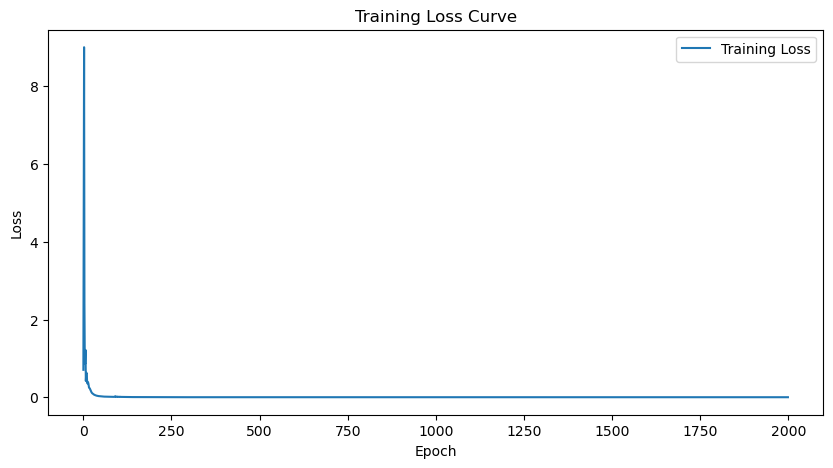

Final Model Accuracy: 67.63%
Final Model F1-score: 0.7007


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.73      0.58      0.65       194
non_infringement       0.64      0.77      0.70       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



/tmp/ipykernel_1146783/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


In [ ]:
print(totaltime_non_infringement)
print(tpot_non_infringement)

print(totaltime_infringement)
print(tpot_infringement)

10.188465577775034
0.03396155192591678
9.454746601512893
0.03151582200504298
